# Analysys of predicted free energies versus experimental measures during COVID Moonshot sprints
The aim of this notebook is to analyze retrospectively the accuracies of free energy calculations of Moonshot sprints to see if there was an increase over time and whether certain choices (protonation states, restraints) were effective or not. 

In [25]:
import scipy
import sklearn
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import json
import seaborn as sns
import urllib.request

In [2]:
def pIC50(IC50_series):
    return -np.log10(IC50_series.astype(float) * 1e-6)

def DeltaG(pIC50):
    kT = 0.593 # kcal/mol for 298 K (25C)
    return - kT * np.log(10.0) * pIC50

def dG_pIC50(dG):
    kT = 0.593 # kcal/mol for 298 K (25C)
    return dG / np.log(10.0) / (- kT)


In [26]:
def get_expt_measures(json_path):
    """From a JSON file, parse experimental measures."""
    
    with urllib.request.urlopen(json_path) as url:
        input_json = json.load(url)
        
    measures = {}
    for cpd in input_json["series"]["compounds"]:
        try:
            measures[cpd["metadata"]["compound_id"]] = [cpd["metadata"]["smiles"],
                                                        cpd["free_energy"]["point"], 
                                                        DeltaG(cpd["metadata"]["experimental_data"]["pIC50"]) ]
            
        except (KeyError, TypeError): # compound has no pred or experimental measure
            pass
    return measures

In [51]:
def plot_scatter(df, split_on=False):
    """Plot a scatter of pred vs expt DG, optionally splitting on sprint number, prot state or restraint form."""
    if not split_on:
        ax = sns.scatterplot(x="pred_dg", y="expt_dg", hue="sprint", data=df)

        ax.plot([-100,100], [-100,100], ls="--", zorder=-5, color="black")

        # some formatting.
        ax.set_xlabel("Predicted $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$")
        ax.set_ylabel("Measured $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$") 

        ax.set_xlim(-20, -2.5)
        ax.set_ylim(-20, -2.5)
        ax.set_title(f"All sprints combined")

    else:
        f, axes = plt.subplots(2,2, figsize=(10,10))
        for (sprint, df_grouped), ax in zip(df.groupby("sprint"), axes.flatten()):

            sns.scatterplot(x="pred_dg", y="expt_dg", hue=split_on, data=df_grouped, ax=ax)

            ax.plot([-100,100], [-100,100], ls="--", zorder=-5, color="black")

            # some formatting.
            ax.set_xlabel("Predicted $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$")
            ax.set_ylabel("Measured $\Delta \mathrm{G}$ / kcal$\cdot$mol$^{-1}$") 

            ax.set_xlim(-20, 0)
            ax.set_ylim(-20, 0)
            ax.set_title(f"Sprint {sprint}")
        plt.tight_layout()
        plt.show()

In [37]:
# get all urls to JSON files.
json_urls = [
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-5/sprint-5-x12073-monomer-neutral/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-7/sprint-7-2021-05-11-stereofilter-P0033-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-8/sprint-8-2021-05-30-P0157-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-10/sprint-10-2021-07-26-x10959-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-10/sprint-10-2021-07-26-x10959-dimer-neutral-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-neutral-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-neutral-restrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-charged-unrestrained/analysis.json",
    "https://fah-public-data-covid19-moonshot-sprints.s3.us-east-2.amazonaws.com/dashboards/sprint-11/sprint-11-2021-12-26-P1800_0A-dimer-charged-restrained/analysis.json",
]


# create a large dataframe of all predictions that have experimental data.
collective = []
for json_path in json_urls:
    # get sprint info.
    print(sprint_details)
    sprint_details = json_path.split("/")[5]
    sprint_num = sprint_details.split("-")[1]
    prot_state = sprint_details.split("-")[-2]
    restrain = sprint_details.split("-")[-1]

    if prot_state == "monomer": # sprint 5 has different url formatting.
        prot_state = "neutral"
        restrain = "restrained" # assumption.

   
    # get pred DG and expt DG from the JSON file.
    sprint_expt_dict = get_expt_measures(json_path)
    if len(sprint_expt_dict) == 0:
        continue # skip the empty sprint 7.
        
    # add all into one DF.
    sprint_df = pd.DataFrame.from_dict(sprint_expt_dict, orient="index")
    sprint_df.columns = ["smiles", "pred_dg", "expt_dg"]
    sprint_df["sprint"] = sprint_num
    sprint_df["protonation_state"] = prot_state
    sprint_df["restrain_form"] = restrain
    
    # add to bucket. 
    collective.append(sprint_df)
    
all_sprints_df = pd.concat(collective)  
all_sprints_df 

sprint-11-2021-12-26-P1800_0A-dimer-charged-restrained
sprint-5-x12073-monomer-neutral
sprint-7-2021-05-11-stereofilter-P0033-dimer-neutral-restrained
sprint-8-2021-05-30-P0157-dimer-neutral-restrained
sprint-10-2021-07-26-x10959-dimer-neutral-restrained
sprint-10-2021-07-26-x10959-dimer-neutral-unrestrained
sprint-11-2021-12-26-P1800_0A-dimer-neutral-unrestrained
sprint-11-2021-12-26-P1800_0A-dimer-neutral-restrained
sprint-11-2021-12-26-P1800_0A-dimer-charged-unrestrained


,smiles,pred_dg,expt_dg,sprint,protonation_state,restrain_form
MAT-POS-8a69d52e-7,C[C@@H]1COc2ccc(cc2[C@@H]1C(=O)Nc3cncc4c3cccc4)Cl,-11.474037,-7.873249,5,neutral,restrained
MAT-POS-11b63608-1,c1ccc2c(c1)cncc2NC(=O)C3CCOc4c3cc(cc4)Br,-8.539094,-8.288342,5,neutral,restrained
DAR-DIA-23aa0b97-19,c1ccc2c(c1)cncc2CC(=O)Nc3cccc(c3)C#N,-11.233291,-6.245234,8,neutral,restrained
DAR-DIA-23aa0b97-20,c1ccc(cc1)NC(=O)Cc2cncc3c2cccc3,-11.447511,-5.790202,8,neutral,restrained
ERI-UCB-ce40166b-6,c1ccc2c(c1)cncc2CC(=O)Nc3cc(cc(c3)Cl)OC4CCC(=O)N4,-10.637404,-6.029705,8,neutral,restrained
...,...,...,...,...,...,...
MAT-POS-853c0ffa-16,COC1(CC1)CS(=O)(=O)N2Cc3ccc(cc3C4(C2)CCN(C4=O)...,-14.074481,-8.716992,11,charged,restrained
ALP-POS-ecbed2ba-2,c1ccc2c(c1)cncc2N3CCC4(C3=O)CN(Cc5c4cc(cc5)Cl)...,-15.133608,-9.115245,11,charged,restrained
MAT-POS-853c0ffa-9,CN(C)CCOc1ccc2cncc(c2c1)N3CCC4(C3=O)CN(Cc5c4cc...,-16.331530,-9.275624,11,charged,restrained
MAT-POS-853c0ffa-10,CN(C)CCOc1ccc2cncc(c2c1)N3CCC4(C3=O)CN(Cc5c4cc...,-15.585297,-9.206188,11,charged,restrained


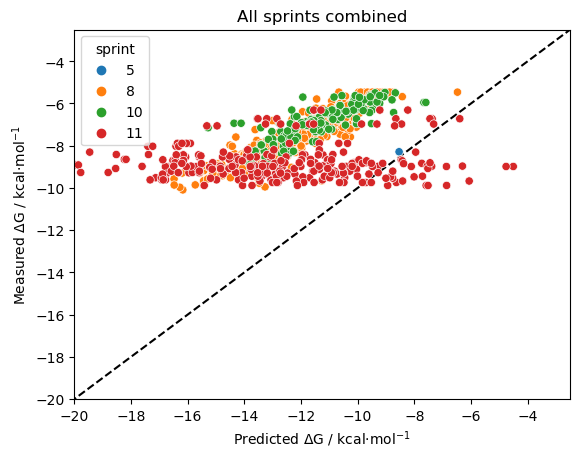

In [52]:
# plot all sprints overlaid
plot_scatter(all_sprints_df)

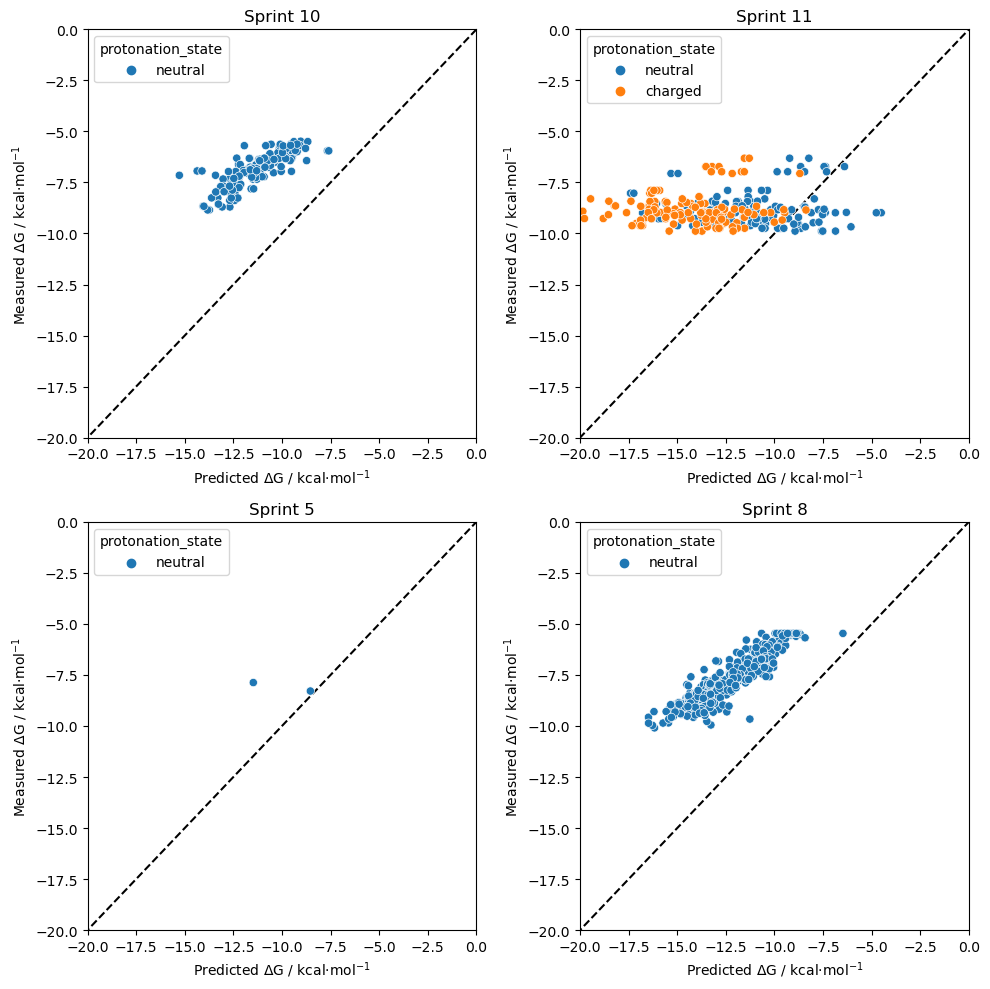

In [53]:
# plot all sprints separately while splitting by protonation state
plot_scatter(all_sprints_df, split_on="protonation_state")

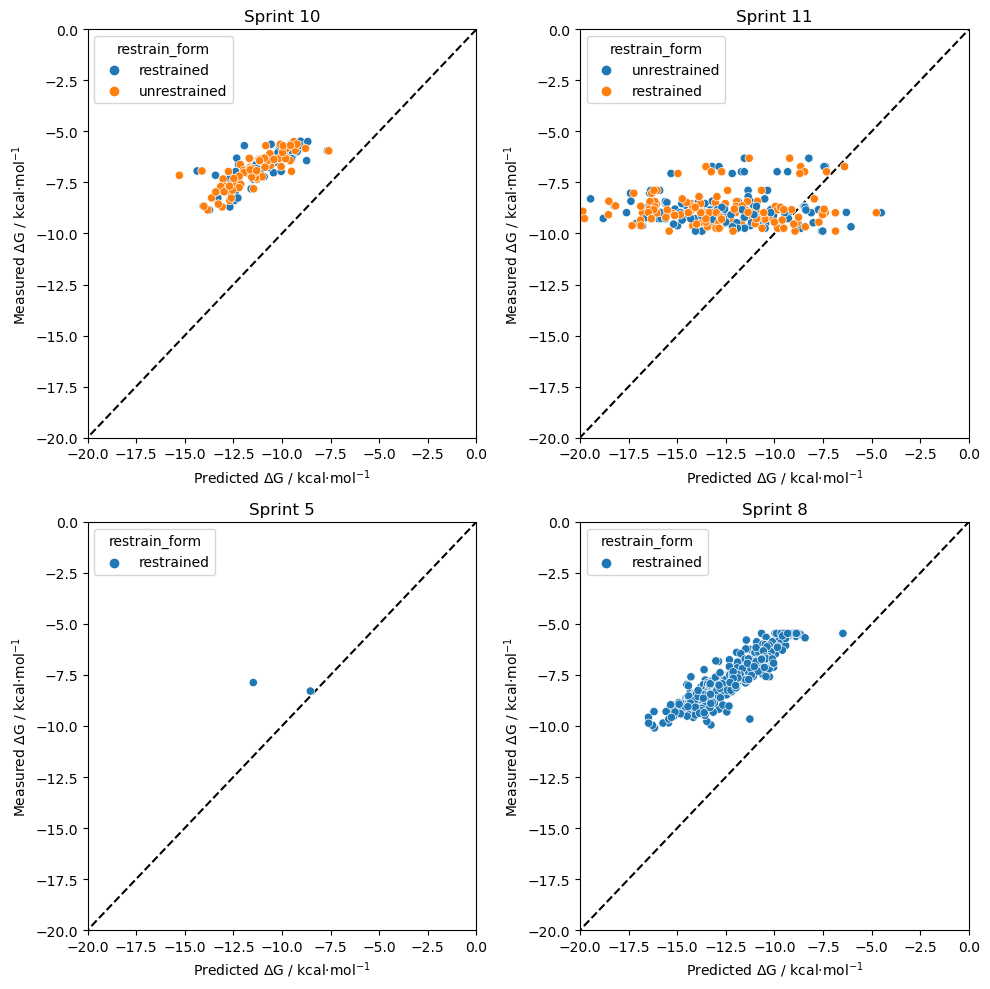

In [54]:
# plot all sprints separately while splitting by restraint form
plot_scatter(all_sprints_df, split_on="restrain_form")

In [ ]:
"""
Can do some statistical analysis or find out if there are any relationships between chemical structures and performance
of certain sprints. Especially sprint 11 seems quite poor - how is that happening?
"""